# Example: Using openEO ML Processes for Foundation Models

In this example, we are using openEO ML processes to compute earth observation embeddings using the [Terramind](https://arxiv.org/abs/2504.11171) Foundation Model.

First, let's make sure the CWD is set to the project root, then inmport all the libraries that we need.
We can ignore the warning that openeo-processes-dask machine learning processes are not loaded. Instead, we are using openeo-processes-dask-ml for machine learning capabilities capabilities.

In [1]:
from pathlib import Path
import os

if Path.cwd().resolve().name == "examples":
    os.chdir("..")
assert Path.cwd().resolve().name == "openeo-processes-dask-ml", "Current CWD is not the Project root (openeo-processes-dask-ml)"

from openeo_pg_parser_networkx.pg_schema import BoundingBox, TemporalInterval

from openeo_processes_dask.process_implementations.cubes import load_stac

from openeo_processes_dask_ml.process_implementations.load_model import load_ml_model
from openeo_processes_dask_ml.process_implementations.ml_predict import ml_predict

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


### Load EO Data
First, we construct the datacube using the openeo load_stac process

In [2]:
eo_cube = load_stac(
    "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a",
    spatial_extent=BoundingBox(
        **{"west": 8.2, "east": 8.5, "south": 48.9, "north": 49.1}
    ),
    #temporal_extent=TemporalInterval(["2024-08-01", "2024-08-15"]),
    temporal_extent=TemporalInterval(["2024-08-05", "2024-08-12"]),
    bands=[
        "coastal",
        "blue",
        "green",
        "red",
        "rededge1",
        "rededge2",
        "rededge3",
        "nir",
        "nir08",
        "nir09",
        "swir16",
        "swir22",
    ],
    resolution=10,
)
eo_cube = eo_cube.compute()
# eo_cube.transpose("time", "bands", "y", "x")

### Load ML Model

Then, we load the ML model using the load_ml_model process. As input, it takes the URI to a STAC Item which catalogs the Terramind model by implementing the [STAC:MLM](https://github.com/stac-extensions/mlm) extension. We also specify the asset where the ML model is found.
We can then inspect ml_object to identify the dimensions and the shape of model input and output.

In [3]:
uri = "examples/mlm_items/terramind_item.json"
asset = "weights"
ml_object = load_ml_model(uri, asset)

model_input_shape = ml_object.model_metadata.input[0].input.shape
model_input_dimensions = ml_object.model_metadata.input[0].input.dim_order
input_info = f"Input dimensions and shape: ({', '.join(model_input_dimensions)}), ({', '.join([str(m) for m in model_input_shape])})"

model_output_shape = ml_object.model_metadata.output[0].result.shape
model_output_dimensions = ml_object.model_metadata.output[0].result.dim_order
output_info = f"Input dimensions and shape: ({', '.join(model_output_dimensions)}), ({', '.join([str(m) for m in model_output_shape])})"

print(f"{input_info}\n{output_info}")

Input dimensions and shape: (batch, band, x, y), (-1, 12, 224, 224)
Input dimensions and shape: (batch, x, y, embedding), (-1, 14, 14, 1024)


### Compute Embeddings

We can now compute embeddings from the datacube using the ml_predict process. This will take some time. Data is downloaded first, and running the Terramind FM is computationally demanding, especially if a CUDA-GPU is unavailable

In [4]:
embeddings_cube = ml_predict(eo_cube, ml_object, ["foo", "bar"])
embeddings_cube

<xarray.DataArray (time: 2, embedding: 1024, y: 140, x: 126)> Size: 145MB
dask.array<transpose, shape=(2, 1024, 140, 126), dtype=float32, chunksize=(2, 1024, 14, 14), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 16B 2024-08-06T10:37:20.222000 2024-08...
  * x            (x) float64 1kB 4.414e+05 4.416e+05 ... 4.613e+05 4.614e+05
  * y            (y) float64 1kB 5.439e+06 5.439e+06 ... 5.417e+06 5.417e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: embedding

In [5]:
embeddings_cube = embeddings_cube.compute()

In [6]:
# x_len = len(embeddings_cube.coords["x"].data)*16
# y_len = len(embeddings_cube.coords["y"].data)*16
# eo_cube = eo_cube.isel(x=range(x_len), y=range(y_len))

# embeddings_cube.isel(time=1).rio.to_raster("./examples/embeddings.tif")
# eo_cube.isel(time=1).rio.to_raster("./examples/image.tif")


### Visualize the Result

Now that the datacube of embeddings is computed, let's plot the results. As such a multi-dimensional datacube is hard to visualize, we will visualize the embedding mean.

First, we will plot them for both timesteps present in the datacube, then we will plot a single time step for better visualization

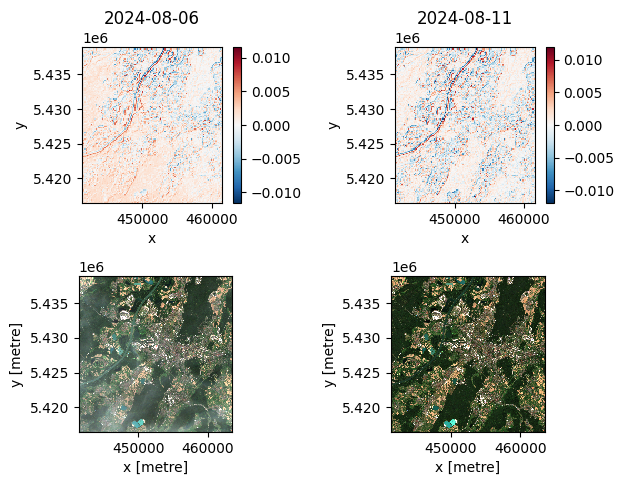

In [7]:
import matplotlib.pyplot as plt

embedding_avg = embeddings_cube.mean(dim="embedding")

n_timesteps = len(eo_cube.coords["time"].data)
fig, ax = plt.subplots(2, n_timesteps)

for t_i in range(n_timesteps):

    t_label = eo_cube.coords["time"].data[t_i].astype("datetime64[D]")

    ax1 = ax[0][t_i]
    ax2 = ax[1][t_i]

    embedding_avg.transpose("y", "x", ...).isel(time=t_i).plot(ax=ax1, add_colorbar=True)

    eo_cube.isel(time=t_i).sel(bands=["red", "green", "blue"]).plot.imshow(ax=ax2, add_colorbar=False, vmin=0, vmax=2000, rgb="bands")
    ax1.set_aspect("equal")
    ax2.set_aspect("equal")

    ax1.set_title(t_label)
    ax2.set_title("")

plt.tight_layout()
plt.show()

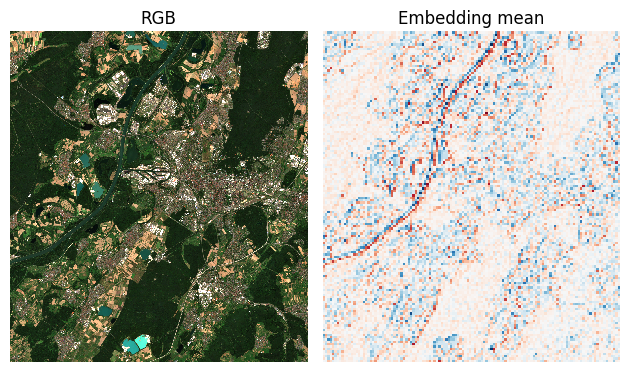

In [8]:
my_dpi = 300
# plt.figure(figsize=(1800/my_dpi, 600/my_dpi), dpi=my_dpi)

x_len = len(embedding_avg.coords["x"].data)*16
y_len = len(embedding_avg.coords["y"].data)*16

fig, (ax1, ax2) = plt.subplots(1, 2)
eo_cube.isel(time=1, x=range(x_len), y=range(y_len)).sel(bands=["red", "green", "blue"]).plot.imshow(ax=ax1, add_colorbar=False, vmin=0, vmax=2000, rgb="bands")
embedding_avg.transpose("y", "x", ...).isel(time=1).plot(ax=ax2, add_colorbar=False)

ax1.set_aspect("equal")
ax2.set_aspect("equal")

ax1.set_title("RGB")
ax2.set_title("Embedding mean")

# turn off axis labels
ax1.axis("off")
ax2.axis("off")

plt.tight_layout()
#plt.savefig("./figure.png", dpi=my_dpi, transparent=True)
plt.show()